# <center>Multi-Sensor DiffuserCam: 2D Recon Performance Assessment</center>
## <center>Diffuser Configuration Testing</center>
<center>_Nico Deshler & Kristina Monakhova_<center>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg as linalg
import os

from PIL import Image
import scipy
import imageio
import scipy.io as sio
import scipy.ndimage.filters as sf
import numpy.fft as fft

plt.rcParams['figure.figsize'] = [10, 10] # define plot size

# 1) Setup Instructions

In the cell below...
- Set num_sources to a whole number {n = [1, 10]} to load in data from a simulated scene with n point sources
- Set num_sensors to a whole number to select 
- set sensor_pix to a 1x2 numpy array containing the desired sensor size

- Set ds_factor to 1 or a multiple of 2 to downsample the images used for reconstruction
- Set testProto boolean to just evaluate the L2 norm of the prototype's simulated measurement
- Set applyGausssFilt boolean and sigma (pixel spread) to relax conditions of the L2-Norm 
- Set sensor_scaling to a 1xn numpy array containing the scaling factors to multiply the sensor size for each iteration of the L2-norm calculation

The entire script is now ready to run!

Note:
_For all simulated image data in this demo, the point sources were positioned randomly on a plane located a distance of 10mm axially from the diffuser._

(<matplotlib.axes._subplots.AxesSubplot at 0x24dc8f5f8d0>,
 Text(0.5,1,'Prototype Measurement'))

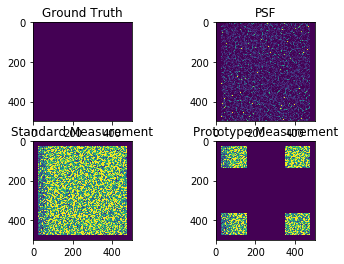

In [7]:
# Sensor and Scene Variables
num_sources = 10;
num_sensors = 2;
#sensor_pix = np.array([100,100])
sensor_pix = [112, 154] # True dimensions of the prototype sensors

# Reconstruction and L2-Norm Variables
ds_factor = 4
applyGaussFilt = False
testProto = False
sigma = 2 
sensor_scaling = np.linspace(2,2,1)
sensor_spacing = np.linspace(0,85,17)
sensor_spacing = np.tile(sensor_spacing, (2,1))


# Image File Directory
path = 'Prototype 2D Recon/2DScenes/num_srcs_' + str(num_sources) + '/'

def imgPrep(imname):
    f_path = path + imname
    im = np.array(Image.open(f_path))
    im = im/np.max(im)
    return im

gt_image = imgPrep('ground_truth.png')
psf = imgPrep('PSF.png')
reg_measurement = imgPrep('std_measurement.png')
proto_measurement = imgPrep('ms_measurement.png')

if applyGaussFilt:
    gt_fmt = np.zeros(np.shape(gt_image))
    sf.gaussian_filter(gt_image, sigma = sigma, output = gt_fmt)
else:
    gt_fmt = gt_image

# Show input images
plt.subplot(2,2,1), plt.imshow(gt_fmt), plt.title('Ground Truth')
plt.subplot(2,2,2), plt.imshow(psf), plt.title('PSF')
plt.subplot(2,2,3), plt.imshow(reg_measurement), plt.title('Standard Measurement')
plt.subplot(2,2,4), plt.imshow(proto_measurement), plt.title('Prototype Measurement')

# Kristina's ADMM Code
------------------------------------------------------------------------------------------------------------------------

In [3]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from PIL import Image
import math
from ipywidgets import interact, widgets

from DiffuserCamUtils import *

In [4]:
def initialize(image, psf, f_lat, f_ax = 1, type = 'pco', color = 'rgb', dim = '2d'):

    if dim == '2d':         #embed into a 3d array
        psf = np.expand_dims(psf, 2)
    psf_bg = np.mean(image[0 : 15, 0 : 15]) #102
    image_bg = np.mean(image[0 : 15, 0 : 15])         #should be around 100
    print(image_bg)

    psf_down = downsample_ax(psf - psf_bg, f_lat)
    image = downsample_ax(image - image_bg, f_lat)

    if dim == '3d':
        psf_down = downsample_lat(psf_down, f_ax)

    image /= np.max(image)
    psf_down /= norm(psf_down)

    return psf_down, image

In [5]:
def ADMMrecon(image, psf, ds_factor):
    
    ###################################################################################################
    dimensions = '2d'
    psf, b = initialize(image, psf, dim = dimensions, f_lat = ds_factor)

    r = 0    #proportion of pixels to crop out
    num_cropped = int(r * b.size)
    crop2d, crop3d, pad2d, pad3d, pix_crop = get_crop_pad(psf, N = num_cropped)
    h = pad2d(psf)    #pad the input stack of h's

    obj_shape = h.shape
    up_shape = psf.shape
    A, AH = get_ops(h, crop2d, pad2d, crop3d, pad3d, up_shape)


    ###################################################################################################
    #setup parameters
    alg = 'admm'
    max_itr = 200
    opt = Options(dimensions, alg, max_itr)
    #opt.gamma = np.real(1.8 / np.max(Hstar * H))
    opt.gamma = 1
    #opt.eps = 7.4e-3        #7.4e-3 for nesterov, 4e-3 for fista
    opt.del_pixels = True
    opt.psf = h
    opt.b = b
    opt.crop2d, opt.pad2d = crop2d, pad2d
    opt.crop3d, opt.pad3d = crop3d, pad3d
    opt.up_shape, opt.pad_shape = up_shape, obj_shape
    opt.autotune = True
    opt.beta = 1.1
    opt.alpha = 1.01

    # tune regularization parameters.
    # 2d tuning: default to 1e-4 on each, tau = 2e-3
    # cartoony: 1e-3, 5e-2, 1e-3, 2e-5
    # to actually see cost function going down, use tau = 1, other mu's = 1e-4
    opt.mu1 = 1e-4
    opt.mu2 = 1e-4
    opt.mu3 = 1e-4
    opt.tau = 2e-3
    ###################################################################################################


    #functions for solver
    grad_func = lambda x : grad(x, A, AH, b)
    error = lambda x : objective(x, A, b, opt.tau)

    #solve
    x, error_list = solver(grad_func, error, non_negative, opt)
    x = crop2d(x)
    return x

-----------------------------------------------------------------------------------------------------------------------------

# Independent Sensor Size and Spacing

(<matplotlib.axes._subplots.AxesSubplot at 0x24dc9fa66a0>,
 <matplotlib.image.AxesImage at 0x24dca1ff780>)

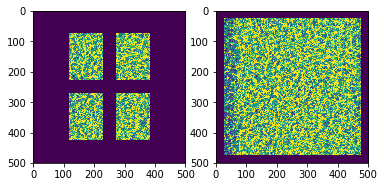

In [6]:
# Returns a masked version of the image.
# dim_sensors, dim_spacing, and sensor_config are parameters
# that define how the appropriate columns of the image will
# be deleted.
% matplotlib inline
def maskIm_simple(im, dim_sensors, dim_spacing, sensor_config):
    # im is input image
    # dim_sensors represented in number of pixels (x pixels, y pixels)
    # dim_spacing sensor spacing represented in number of pixels (x pixels, y pixels)
    # sensor_config input (num sensors in x, num sensors in y)
    
    im_dims = np.shape(im)
    masked_im = np.copy(im)
    
    # Set image to zero beyond the extent of the sensor array
    half_range_x = ((sensor_config[0] * dim_sensors[0]) + ((sensor_config[0]) * dim_spacing[0]))//2
    half_range_y = ((sensor_config[1] * dim_sensors[1]) + ((sensor_config[1]) * dim_spacing[1]))//2
    x_lims = [(im_dims[0]//2 - half_range_x), (im_dims[0]//2 + half_range_x)] 
    y_lims = [(im_dims[1]//2 - half_range_y), (im_dims[1]//2 + half_range_y)] 
    
    masked_im[:, 0:x_lims[0]] = 0
    masked_im[:, x_lims[1]:] = 0
    masked_im[0:y_lims[0], :] = 0
    masked_im[y_lims[1]:, :] = 0
    
    # Identify centers of spacing regions
    mid_xs = np.arange(x_lims[0], x_lims[1]+1, dim_sensors[0] + dim_spacing[0])
    mid_ys = np.arange(y_lims[0], y_lims[1]+1, dim_sensors[1] + dim_spacing[1])
  
    pad_x = dim_spacing[0]//2
    pad_y = dim_spacing[1]//2

    #Zero the columns not in line with the sensors
    for x in np.nditer(mid_xs):
        masked_im[:, max(x-pad_x, 0):min(x+pad_x, im_dims[0])] = 0
        
    #Zero the elements not in line with the sensors
    for y in np.nditer(mid_ys):
        masked_im[max(y-pad_y, 0):min(y+pad_y, im_dims[1]),:] = 0
        
    return masked_im
    

outIm = maskIm_simple(reg_measurement, sensor_pix, [40,40], [2,2])
plt.figure()
plt.subplot(1,2,1), plt.imshow(outIm)
plt.subplot(1,2,2), plt.imshow(reg_measurement)


Sensor Config: 1 of 17
0.0
mu1 = 0.0001, mu2 = 0.0001, mu3 = 0.0001, tau = 0.002
Autotuning with alpha = 1.01, beta = 1.1
Iteration number 20. mu1: 1.2e-04. mu2: 1.2e-04. mu3: 1.2e-04
Iteration number 40. mu1: 1.5e-04. mu2: 1.5e-04. mu3: 1.5e-04
Iteration number 60. mu1: 1.8e-04. mu2: 1.8e-04. mu3: 1.8e-04
Iteration number 80. mu1: 2.2e-04. mu2: 2.2e-04. mu3: 2.2e-04
Iteration number 100. mu1: 2.7e-04. mu2: 2.7e-04. mu3: 2.7e-04
Iteration number 120. mu1: 3.3e-04. mu2: 3.3e-04. mu3: 3.3e-04
Iteration number 140. mu1: 4.1e-04. mu2: 4.1e-04. mu3: 4.1e-04
Iteration number 160. mu1: 5.0e-04. mu2: 5.0e-04. mu3: 5.0e-04
Iteration number 180. mu1: 6.1e-04. mu2: 6.1e-04. mu3: 6.1e-04
L2-NORM -------- 6.864164048395078
Sensor Config: 2 of 17
0.0
mu1 = 0.0001, mu2 = 0.0001, mu3 = 0.0001, tau = 0.002
Autotuning with alpha = 1.01, beta = 1.1
Iteration number 20. mu1: 1.2e-04. mu2: 1.2e-04. mu3: 1.2e-04
Iteration number 40. mu1: 1.5e-04. mu2: 1.5e-04. mu3: 1.5e-04
Iteration number 60. mu1: 1.8e-04.

Iteration number 80. mu1: 2.2e-04. mu2: 2.2e-04. mu3: 2.2e-04
Iteration number 100. mu1: 2.7e-04. mu2: 2.7e-04. mu3: 2.7e-04
Iteration number 120. mu1: 3.3e-04. mu2: 3.3e-04. mu3: 3.3e-04
Iteration number 140. mu1: 4.1e-04. mu2: 4.1e-04. mu3: 4.1e-04
Iteration number 160. mu1: 5.0e-04. mu2: 5.0e-04. mu3: 5.0e-04
Iteration number 180. mu1: 6.1e-04. mu2: 6.1e-04. mu3: 6.1e-04
L2-NORM -------- 7.244300846813502
Sensor Config: 13 of 17
0.0
mu1 = 0.0001, mu2 = 0.0001, mu3 = 0.0001, tau = 0.002
Autotuning with alpha = 1.01, beta = 1.1
Iteration number 20. mu1: 1.2e-04. mu2: 1.2e-04. mu3: 1.2e-04
Iteration number 40. mu1: 1.5e-04. mu2: 1.5e-04. mu3: 1.5e-04
Iteration number 60. mu1: 1.8e-04. mu2: 1.8e-04. mu3: 1.8e-04
Iteration number 80. mu1: 2.2e-04. mu2: 2.2e-04. mu3: 2.2e-04
Iteration number 100. mu1: 2.7e-04. mu2: 2.7e-04. mu3: 2.7e-04
Iteration number 120. mu1: 3.3e-04. mu2: 3.3e-04. mu3: 3.3e-04
Iteration number 140. mu1: 4.1e-04. mu2: 4.1e-04. mu3: 4.1e-04
Iteration number 160. mu1: 5

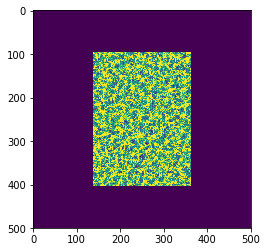

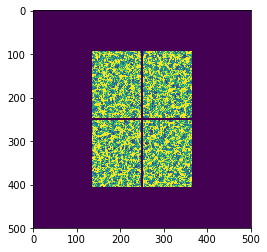

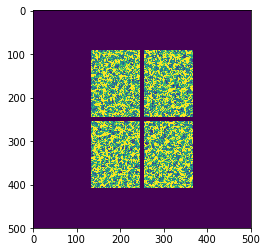

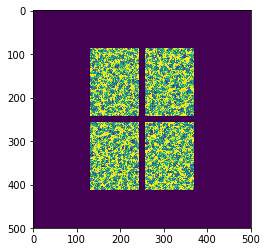

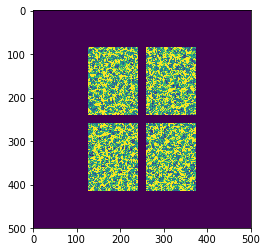

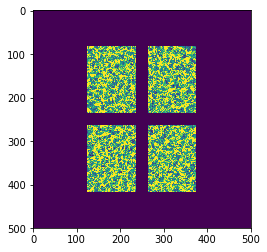

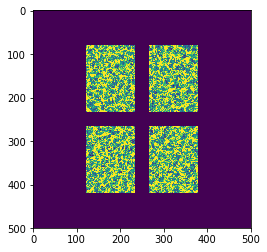

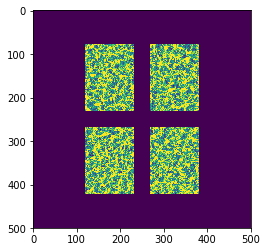

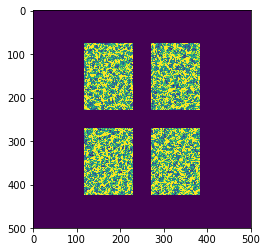

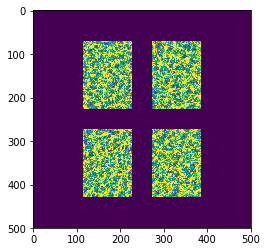

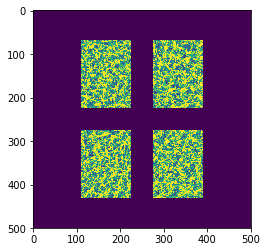

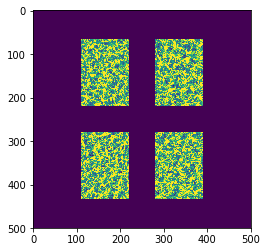

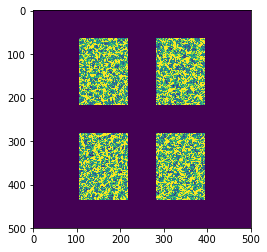

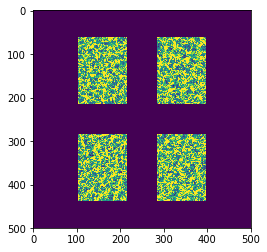

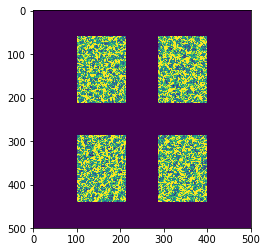

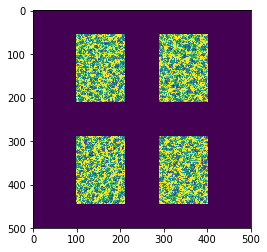

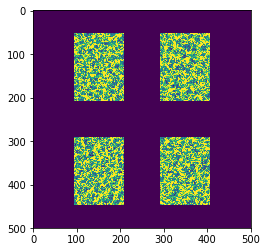

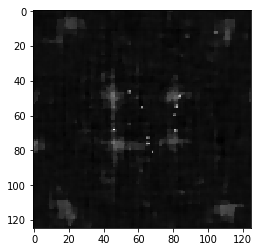

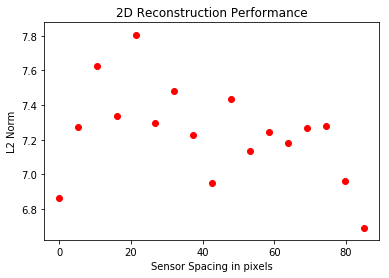

In [13]:
# SIMPLE MASK --> IV 's = SPACING
% matplotlib inline
results = np.zeros((1, np.shape(sensor_spacing)[1]))

# prep ground truth image
gt = downsample_ax(gt_fmt, ds_factor)
gt /= np.max(gt)
gt = np.rot90(np.rot90(gt))

num_configs = np.shape(sensor_spacing)[1]
i = 0
while i < num_configs:
    print("Sensor Config: " + str(i+1) + " of " + str(num_configs))

    # Adjust sensor configuration
    ms = maskIm_simple(reg_measurement, sensor_pix, sensor_spacing[:,i].astype(int), [2,2])
    plt.imshow(ms)

    # Reconstruct and compute L2
    recon_im = ADMMrecon(ms, psf, ds_factor)
    recon_im /= np.max(recon_im)
    n = linalg.norm(recon_im[:,:,0] - gt)

    # Store results
    results[0,i] = n
    print("L2-NORM -------- " + str(n))
    i = i + 1



# Plot results
x = sensor_spacing[0,:]
y = results
fig = plt.figure()
plt.scatter(x,y, c='r')
plt.title('2D Reconstruction Performance')
plt.xlabel('Sensor Spacing in pixels')
plt.ylabel('L2 Norm')

fig.savefig("Sensor Size and Spacing 2D Recon L2 Data.png")


In [37]:
def get_crop_pad(psf, N = 0):

    up3d = np.array(psf.shape)
    up_shape = up3d[0 : 2]      #unpadded shape. don't care about zstack
    padded_shape = 2 * up_shape
    pad_shape_3d = (padded_shape[0], padded_shape[1], up3d[2])      #pad x and y, not z.

    start_crop = (padded_shape - up_shape) // 2
    end_crop = start_crop + up_shape

    # generate random incides to crop out
    (X, Y) = up_shape
    max_idx = X * Y
    rng = np.arange(max_idx)
    np.random.shuffle(rng)
    pixels = rng[:N]
    pixels = [(p % X, p // X) for p in pixels]

    # del_pixels: if true, will randomly delete N pixels.
    def crop2d(x, del_pixels = False):
        if len(x.shape) == 2:
            cropped = x[start_crop[0] : end_crop[0], start_crop[1] : end_crop[1]]
            if del_pixels and N > 0:
                cropped = pix_crop(cropped)
        elif len(x.shape) == 3:
            zsize = x.shape[2]
            cropped = np.zeros((up_shape[0], up_shape[1], zsize), 'float32')
            for z in range(zsize):
                cropped[:, :, z] = np.real(x[start_crop[0] : end_crop[0], start_crop[1] : end_crop[1], z])
                if del_pixels and N > 0:
                    cropped[:, :, z] = pix_crop(cropped[:, :, z])
        else:
            raise Exception('Object to crop must be 2d or 3d.')
        return cropped

    def pad2d(x, del_pixels = False):
        if del_pixels:
            x = pix_crop(x)
        if len(x.shape) == 2:
            padded = np.zeros(padded_shape, np.complex64)
            padded[start_crop[0] : end_crop[0], start_crop[1] : end_crop[1]] = x
        elif len(x.shape) == 3:
            padded = np.zeros((padded_shape[0], padded_shape[1], x.shape[2]), np.complex64)
            for z in range(x.shape[2]):
                padded[start_crop[0] : end_crop[0], start_crop[1] : end_crop[1], z] = x[:, :, z]
        else:
            raise Exception('Object to pad must be 2d or 3d.')
        return padded

    # 3d crop used in forward model. Performs a 2d crop over all slices and then
    # returns the z = 0 slice.
    def crop3d(x, del_pixels = False):
        return crop2d(x, del_pixels)[:, :, 0]

    # embeds 2d padded slice of x into the z = 0 slice of a 3d array with shape
    # pad_shape_3d
    def pad3d(x, del_pixels = False):
        padded = np.zeros(pad_shape_3d)
        padded[:, :, 0] = np.real(pad2d(x, del_pixels))         #embed the padded figure into the stack
        return padded

    def pix_crop(x):
        for (i, j) in pixels:
            x[i, j] = 0
        return x

    return crop2d, crop3d, pad2d, pad3d, pix_crop


crop2d, crop3d, pad2d, pad3d, pix_crop = get_crop_pad(np.reshape(downsample_ax(psf,4), (125, 125, 1)))



h = np.reshape(psf, (500, 500, 1))
np.shape(psf)
H = fftn(ifftshift(pad2d(downsample_ax(h, 4))), norm = 'ortho')
Hstar = np.conj(H)
A = lambda x : np.real(fftshift(ifftn(H * fftn(ifftshift(pad2d(downsample_ax(x, 4))), norm = 'ortho'), norm = 'ortho')))


test = A(gt_image)

In [34]:
h = np.reshape(psf, (500, 500, 1))
np.shape(psf)
H = fftn(ifftshift(pad2d(downsample_ax(h, 4))), norm = 'ortho')
Hstar = np.conj(H)
A = lambda x : np.real(fftshift(ifftn(H * fftn(ifftshift(pad2d(downsample_ax(x, 4))), norm = 'ortho'), norm = 'ortho')))


test = A(gt_image)


ValueError: could not broadcast input array from shape (125,125) into shape (500,500)

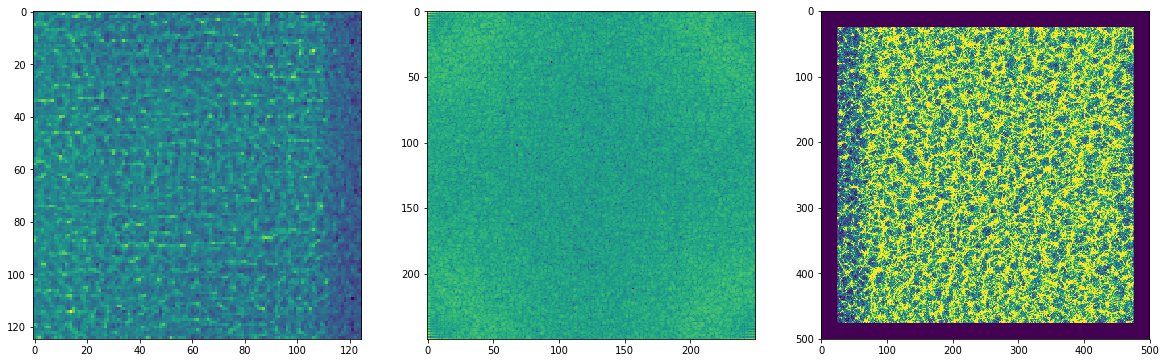

In [39]:
test1 = crop2d(test)
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(test1[:,:,0])
plt.subplot(1,3,2)
plt.imshow(np.log10(np.abs(H[:,:,0])))
plt.subplot(1,3,3)
plt.imshow(reg_measurement)

# Source Alignment Check

1.3857931e-20
mu1 = 0.0001, mu2 = 0.0001, mu3 = 0.0001, tau = 0.002
Autotuning with alpha = 1.01, beta = 1.1
Iteration number 20. mu1: 1.2e-04. mu2: 1.2e-04. mu3: 1.2e-04
Iteration number 40. mu1: 1.5e-04. mu2: 1.5e-04. mu3: 1.5e-04
Iteration number 60. mu1: 1.8e-04. mu2: 1.8e-04. mu3: 1.8e-04
Iteration number 80. mu1: 2.2e-04. mu2: 2.2e-04. mu3: 2.2e-04
Iteration number 100. mu1: 2.7e-04. mu2: 2.7e-04. mu3: 2.7e-04
Iteration number 120. mu1: 3.3e-04. mu2: 3.3e-04. mu3: 3.3e-04
Iteration number 140. mu1: 4.1e-04. mu2: 4.1e-04. mu3: 4.1e-04
Iteration number 160. mu1: 5.0e-04. mu2: 5.0e-04. mu3: 5.0e-04
Iteration number 180. mu1: 6.1e-04. mu2: 6.1e-04. mu3: 6.1e-04


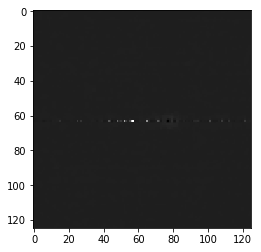

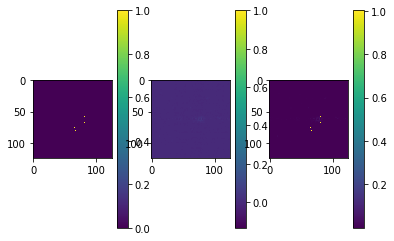

In [40]:
# SIMPLE MASK --> IV 's = SPACING
% matplotlib inline
# prep ground truth image
gt = downsample_ax(gt_fmt, ds_factor)
gt /= np.max(gt)
gt = np.rot90(np.rot90(gt))


# Reconstruct and compute L2
recon_im = ADMMrecon(test1[:,:,0], downsample_ax(psf,4), 1)
recon_im /= np.max(recon_im)
n = linalg.norm(recon_im[:,:,0] - gt)


# Plot Images and colorbars
plt.figure()
plt.subplot(1,3,1)
plt.imshow(gt)
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(recon_im[:,:,0])
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.abs(recon_im[:,:,0]-gt))
plt.colorbar()


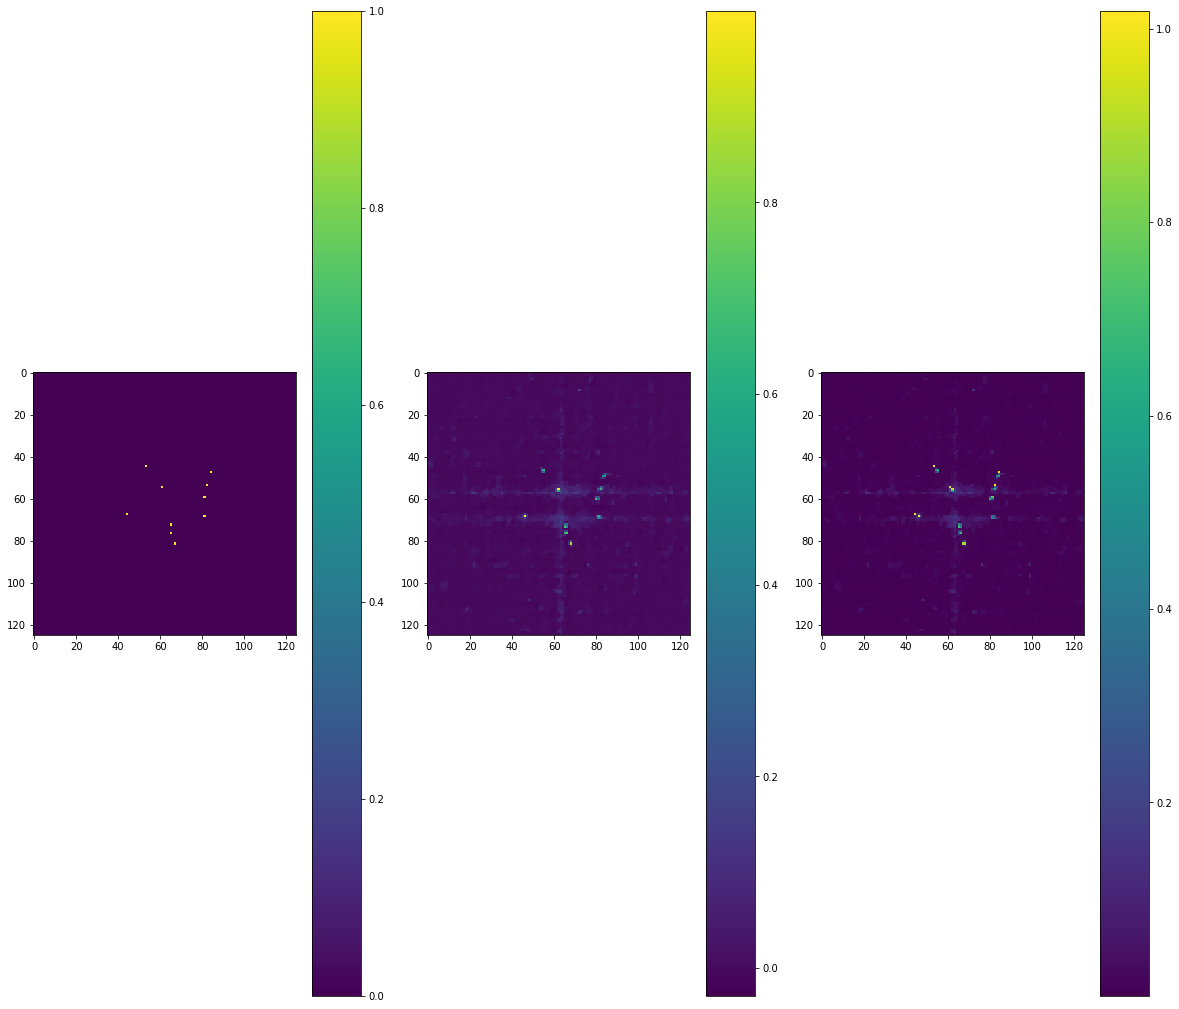

In [9]:
# Plot Images and colorbars
plt.figure(figsize=(20,20))

plt.subplot(1,3,1)
plt.imshow(gt)
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(recon_im[:,:,0])
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.abs(recon_im[:,:,0]-gt))
plt.colorbar()



# Multi-Sensor v. Single Sensor Scale Testing

In [49]:
# Returns a masked version of the image.
# Couples the sensor size with the spacing. (i.e. sensors are always centered about the geometric divisions of the )
# how the appropriate columns of the image will
# be deleted.
def maskIm(im, dim_sensors, num_sensors): 
    imDim = np.shape(im)
    spacing = np.floor((imDim - dim_sensors * num_sensors)/num_sensors)
    if spacing[0] < 0 or spacing[1] < 0:
        raise Exception("Sensors overlap! Consider reducing sensor size or number of sensors.")
    
    # Make binary sensor matrix with zero padding for spacing
    sensor = np.ones(dim_sensors)
    padR = int(spacing[0]/2)    
    padC = int(spacing[1]/2)
    sensor = np.pad(sensor, ((padR,padR),(padC,padC)), 'constant', constant_values = 0)
    maskRow = sensor
  
    i,j = 1,1
    
    # Build a mask row by stacking sensors horizontally
    while j < num_sensors:
        maskRow = np.hstack((maskRow, sensor))
        j = j + 1
      
    # Build the mask by stacking mask rows vertically 
    mask = maskRow
    while i < num_sensors:
        mask = np.vstack((mask, maskRow))
        i = i + 1
    
    # Enforce dimensional equality between mask and input image
    mskDim = np.shape(mask)
    fill = np.subtract(imDim, mskDim)
    mask = np.pad(mask, ((0,int(fill[0])), (0,int(fill[1]))), 'constant', constant_values = 0)    
    
    return np.multiply(im, mask)

Sensor Config: 1 of 1
0.0


<IPython.core.display.Javascript object>


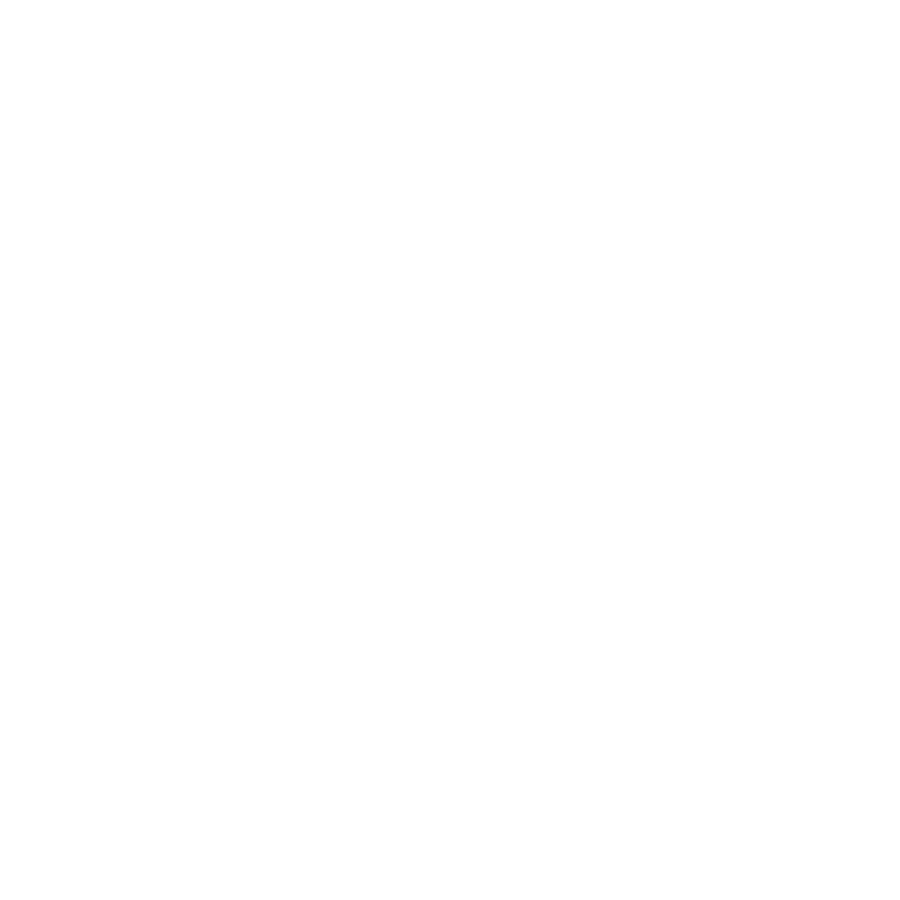

mu1 = 0.0001, mu2 = 0.0001, mu3 = 0.0001, tau = 0.002
Autotuning with alpha = 1.01, beta = 1.1
Iteration number 20. mu1: 1.2e-04. mu2: 1.2e-04. mu3: 1.2e-04
Iteration number 40. mu1: 1.5e-04. mu2: 1.5e-04. mu3: 1.5e-04
Iteration number 60. mu1: 1.8e-04. mu2: 1.8e-04. mu3: 1.8e-04
Iteration number 80. mu1: 2.2e-04. mu2: 2.2e-04. mu3: 2.2e-04
Iteration number 100. mu1: 2.7e-04. mu2: 2.7e-04. mu3: 2.7e-04
Iteration number 120. mu1: 3.3e-04. mu2: 3.3e-04. mu3: 3.3e-04
Iteration number 140. mu1: 4.1e-04. mu2: 4.1e-04. mu3: 4.1e-04
Iteration number 160. mu1: 5.0e-04. mu2: 5.0e-04. mu3: 5.0e-04
Iteration number 180. mu1: 6.1e-04. mu2: 6.1e-04. mu3: 6.1e-04
L2-NORM -------- 54.17993301679272


<IPython.core.display.Javascript object>


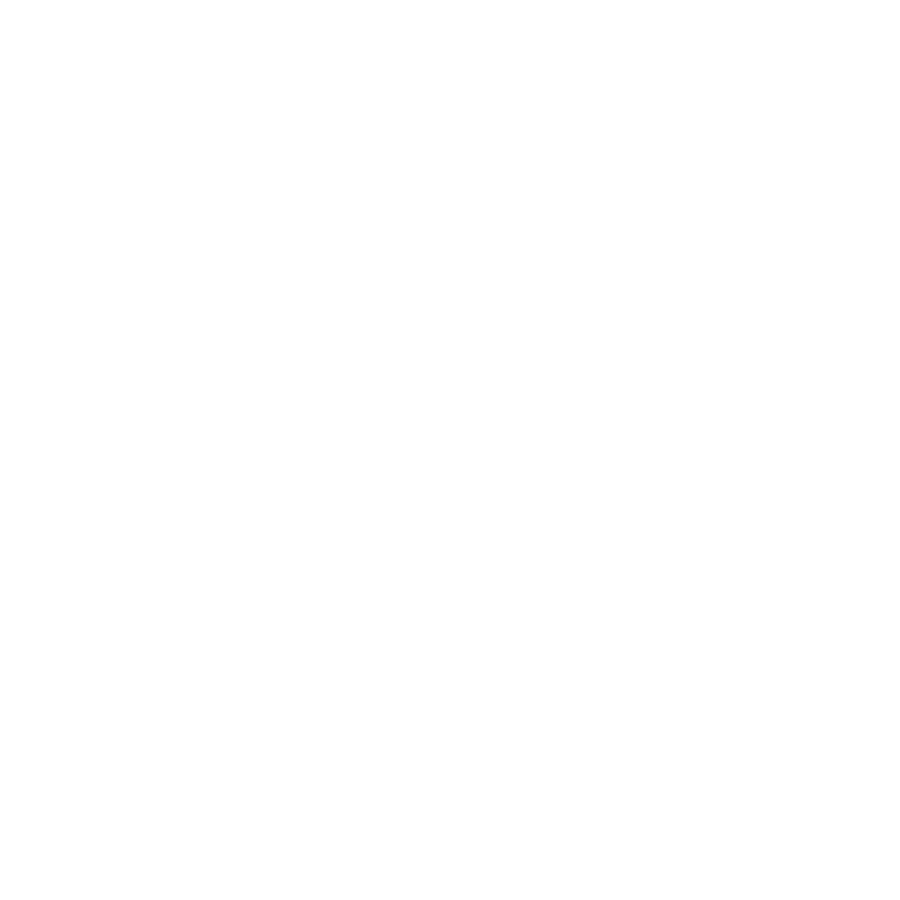

In [106]:
# COUPLED MASK --> IV'S = SPACING, SENSOR SIZE
results = np.zeros((1,np.size(sensor_scaling)))

gt = np.rot90(np.rot90(gt))
# Just prototype's simulated measurement
if testProto:
    # Reconstruct and compute L2
    recon_im = ADMMrecon(proto_measurement, psf, ds_factor)
    gt = downsample_ax(gt_fmt, ds_factor)
    gt /= np.max(gt)
    recon_im /= np.max(recon_im)
    n = linalg.norm(recon_im - gt)
    print("PROTOTYPE L2-NORM -------- " + str(n))

else:
    i = 0
    while i < np.size(sensor_scaling):

        print("Sensor Config: " + str(i+1) + " of " + str(np.size(sensor_scaling)))

        # Adjust sensor configuration
        sensor_size = np.round(sensor_pix * sensor_scaling[i])
        ms = maskIm(reg_measurement,sensor_size.astype(int), num_sensors)

        # Reconstruct and compute L2
        recon_im = ADMMrecon(ms, psf, ds_factor)
        gt = downsample_ax(gt_fmt, ds_factor)
        gt /= np.max(gt)
        recon_im /= np.max(recon_im)
        n = linalg.norm(recon_im - gt)

        # Store results
        results[0,i] = n
        print("L2-NORM -------- " + str(n))

        i = i + 1
    
    
    
# Show the reconstruction
#plt.subplot(2,2,1), plt.imshow(ms), plt.title('Multi_Sensor Measurement')
#plt.subplot(2,2,2), plt.imshow(recon_im[:,:]/np.max(recon_im)), plt.title('Normalized Reconstruction')
#plt.subplot(2,2,3), plt.imshow(recon_im > np.sort(recon_im.flatten())[-3000]), plt.title('Thresholded Reconstruction')
#plt.subplot(2,2,4), plt.imshow(gt), plt.title('L2 Ground Truth')

<IPython.core.display.Javascript object>


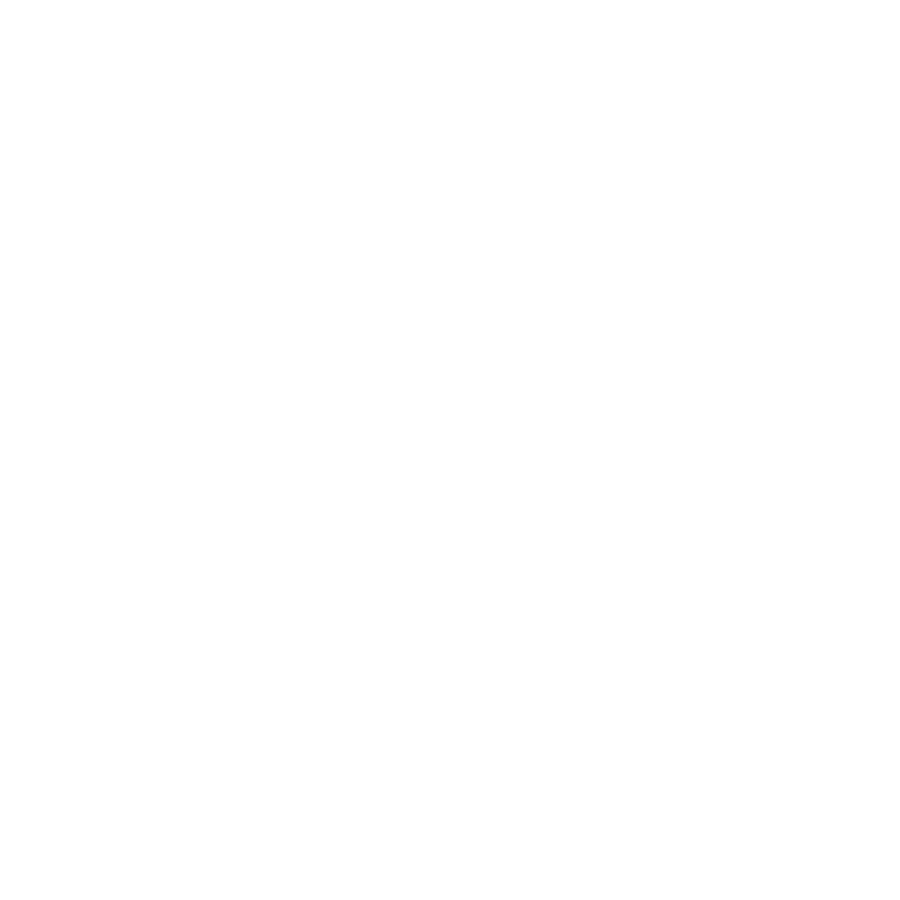

<IPython.core.display.Javascript object>


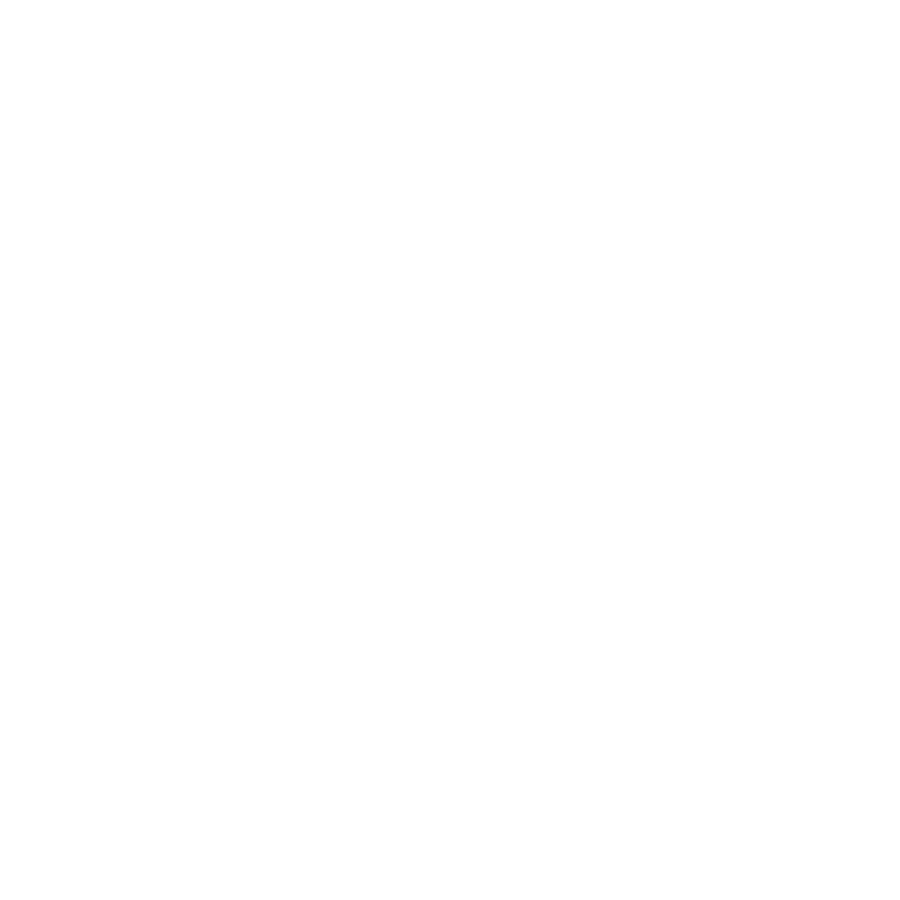

In [101]:
%matplotlib notebook

plt.figure()
plt.subplot(1,3,1)
plt.imshow(gt)
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(recon_im[:,:,0])
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.abs(recon_im[:,:,0]-gt))
plt.colorbar()


# Graph Results

<IPython.core.display.Javascript object>


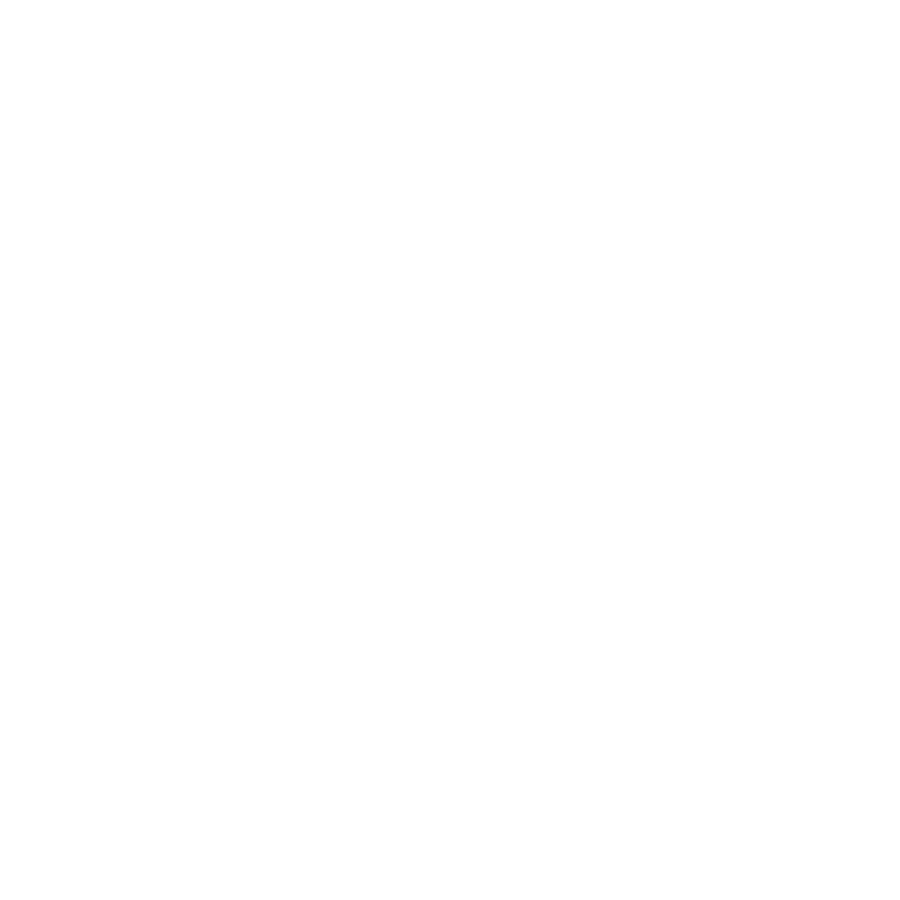

ValueError: x and y must be the same size

<IPython.core.display.Javascript object>


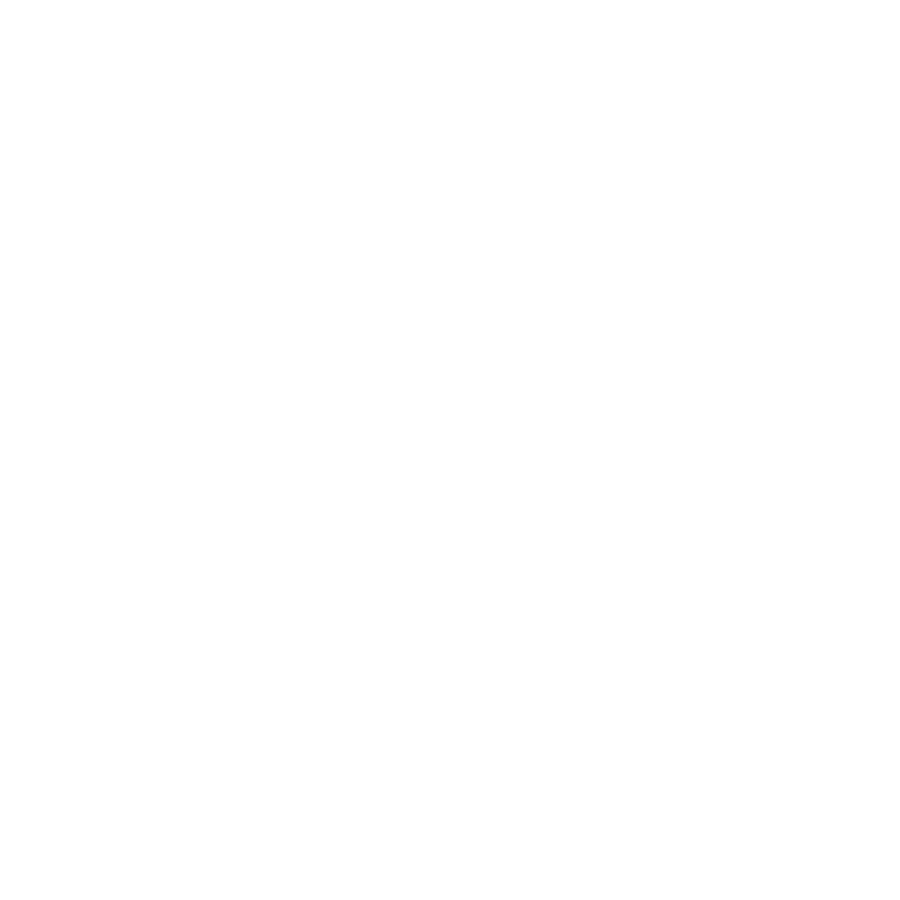

In [102]:
x = sensor_scaling * sensor_pix[0]
y = results
plt.figure()
plt.scatter(x,y, c='r')
plt.title('2D Reconstruction Performance')
plt.xlabel('Sensor Size')
plt.ylabel('L2 Norm')